
### 1. Einleitung und Laden der Python-Pakete

Die folgenden Python-Pakete stammen u.a. aus dem TU-Kurs "Data Science" und den Python-Modulen "TextBlob" und "NLTK" (Natural Language Toolkit) und weiteren obligatorischen Paketen und Modulen von Python, welche die Analyse und Darstellung der Twitter Daten und der Ergebnisse unterstützen.

Um die vollständigen Tabellen zu sichten, kann der Befehl tbl.show() verwendet werden bspw. in Zeile 2: "nyt_table.show()" anstelle von "nyt_table". Da es sich bei allen behandelten Twitter-Accounts um große Datenmengen von mehreren tausend Tweets handelt, wurde für die Veranschaulichung der Skripte im .pdf-Format auf eine vollständige Darstellung aller Tabellen verzichtet, um eine angemessene Seitenzahl zu bewahren. Stattdessen werden bei großen Tabellen, welche die gesamte Tweetanzahl beinhalten, jeweils die ersten zehn Einträge abgebildet.

Einzelne Arbeitsschritte werden innerhalb der Zeilen mittels der Python-Kommentarfunktion "#" beschrieben.

In [1]:
from datascience import *
import numpy as np
import pandas as pd
import math
import scipy
import statistics
import tweepy as tw
import io 
import tables
import regex as re
import os
import networkx
import warnings
warnings.filterwarnings("ignore")
import spacy
from bs4 import BeautifulSoup
import collections
import itertools
from lexical_diversity import lex_div as ld

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

import textblob as TextBlob
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.taggers import NLTKTagger

### 2. Datenaufbereitung

In [2]:
# Laden der vom Skript gecrawlten .csv Tabelle.
nyt_table = Table.read_table("C:/Users/cati_/Desktop/Sentiment_Data_Try/ALL_NYT_Tweets.csv", names=['User', 'Tweet_Nr', 'Date_Time', 'Text'])
nyt_table
#nyt_table.show()

User,Tweet_Nr,Date_Time,Text
nytimes,1272931961330335747,2020-06-16 16:40:04,b'“I know it's an A.I. I know it's not a person” one use ...
nytimes,1272926948415725578,2020-06-16 16:20:08,b'Reports of new coronavirus cases continue to decrease ...
nytimes,1272921975682457607,2020-06-16 16:00:23,b'Conservative Christian groups say Monday's U.S. Suprem ...
nytimes,1272919378976268288,2020-06-16 15:50:04,b'“The police are in some respects a border patrol and t ...
nytimes,1272916866563026946,2020-06-16 15:40:05,"b'""""""""""""""""People are desperate for change. People are fi ..."
nytimes,1272911833062572032,2020-06-16 15:20:05,b'European regulators are questioning whether Apple's te ...
nytimes,1272906853333250052,2020-06-16 15:00:17,"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ..."
nytimes,1272902866202746884,2020-06-16 14:44:27,b'A prosecutor who quit the Roger Stone case after Attor ...
nytimes,1272901767030849536,2020-06-16 14:40:05,b'Cases of the coronavirus in prisons and jails across t ...
nytimes,1272896747036184576,2020-06-16 14:20:08,b'News Analysis: Social movements are almost always mess ...


In [3]:
# Auswahl der relevanten Spalten für die Datenbereinigung.
nyt_first = nyt_table.select("Text", "Date_Time", "Tweet_Nr")
nyt_first

Text,Date_Time,Tweet_Nr
b'“I know it's an A.I. I know it's not a person” one use ...,2020-06-16 16:40:04,1272931961330335747
b'Reports of new coronavirus cases continue to decrease ...,2020-06-16 16:20:08,1272926948415725578
b'Conservative Christian groups say Monday's U.S. Suprem ...,2020-06-16 16:00:23,1272921975682457607
b'“The police are in some respects a border patrol and t ...,2020-06-16 15:50:04,1272919378976268288
"b'""""""""""""""""People are desperate for change. People are fi ...",2020-06-16 15:40:05,1272916866563026946
b'European regulators are questioning whether Apple's te ...,2020-06-16 15:20:05,1272911833062572032
"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ...",2020-06-16 15:00:17,1272906853333250052
b'A prosecutor who quit the Roger Stone case after Attor ...,2020-06-16 14:44:27,1272902866202746884
b'Cases of the coronavirus in prisons and jails across t ...,2020-06-16 14:40:05,1272901767030849536
b'News Analysis: Social movements are almost always mess ...,2020-06-16 14:20:08,1272896747036184576


In [4]:
# Entfernung der byte-Kennzeichnung b' und b" zu Beginn der Tweets. 
nyt_without_b = [tweet.strip("b") for tweet in nyt_first.column("Text")]

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_second = nyt_first.with_column("Without Byte", nyt_without_b)
nyt_second

Text,Date_Time,Tweet_Nr,Without Byte
b'“I know it's an A.I. I know it's not a person” one use ...,2020-06-16 16:40:04,1272931961330335747,'“I know it's an A.I. I know it's not a person” one user ...
b'Reports of new coronavirus cases continue to decrease ...,2020-06-16 16:20:08,1272926948415725578,'Reports of new coronavirus cases continue to decrease a ...
b'Conservative Christian groups say Monday's U.S. Suprem ...,2020-06-16 16:00:23,1272921975682457607,'Conservative Christian groups say Monday's U.S. Supreme ...
b'“The police are in some respects a border patrol and t ...,2020-06-16 15:50:04,1272919378976268288,'“The police are in some respects a border patrol and th ...
"b'""""""""""""""""People are desperate for change. People are fi ...",2020-06-16 15:40:05,1272916866563026946,"'""""""""""""""""People are desperate for change. People are fig ..."
b'European regulators are questioning whether Apple's te ...,2020-06-16 15:20:05,1272911833062572032,'European regulators are questioning whether Apple's ter ...
"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ...",2020-06-16 15:00:17,1272906853333250052,"""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced o ..."
b'A prosecutor who quit the Roger Stone case after Attor ...,2020-06-16 14:44:27,1272902866202746884,'A prosecutor who quit the Roger Stone case after Attorn ...
b'Cases of the coronavirus in prisons and jails across t ...,2020-06-16 14:40:05,1272901767030849536,'Cases of the coronavirus in prisons and jails across th ...
b'News Analysis: Social movements are almost always mess ...,2020-06-16 14:20:08,1272896747036184576,'News Analysis: Social movements are almost always messy ...


In [5]:
# Erweiterte Legende zur Übersetzung der Kontraktionen.
CONTRACTION_MAP = {
"ain't": "is not",
"amn't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"'cuz": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"daren't": "dare not",
"daresn't": "dare not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"e'er": "ever",
"everyone's": "everyone is",
"finna": "going to",
"gimme": "give me",
"giv'n": "given",
"gonna": "going to",
"gon't": "go not",
"gotta": "got to",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"he've": "he have",
"how'd": "how did",
"how'd'y": "how do you",
"howdy": "how do you do",
"how'll": "how will",
"how're": "how are",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i'm'a": "i am about to",
"i'm'o": "i am going to",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"may've": "may have",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"ne'er": "never",
"o'clock": "of the clock",
"o'er": "over",
"ol'": "old",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shalln't": "shall not",
"shan't": "shall not",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"somebody's": "somebody has",
"someone's": "someone has",
"something's": "something has",
"so're": "so are",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that'll": "that shall",
"that'r": "that are",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there'll": "there will",
"there're": "there are",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"this's": "this is",
"those're": "those are",
"'tis": "it is",
"to've": "to have",
"'twas": "it was",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'd": "what did",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where're": "where are",
"where's": "where is",
"where've": "where have",
"which's": "which has",
"who'd": "who would",
"who'd've": "who would have",
"who'll": "who will",
"who'll've": "who will have",
"who're": "who are",
"who's": "who is",
"who've": "who have",
"why'd": "why did",
"why're": "why are",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [6]:
# Funktion zur Übersetzung der Kontraktionen mittels der erstellten Legende.
def expand_contractions(txt, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, txt)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
nyt_contractions = nyt_second.apply(expand_contractions, "Without Byte") 

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_third = nyt_second.with_column("Without Contractions", nyt_contractions)
nyt_third

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions
b'“I know it's an A.I. I know it's not a person” one use ...,2020-06-16 16:40:04,1272931961330335747,'“I know it's an A.I. I know it's not a person” one user ...,“I know it is an A.I. I know it is not a person” one use ...
b'Reports of new coronavirus cases continue to decrease ...,2020-06-16 16:20:08,1272926948415725578,'Reports of new coronavirus cases continue to decrease a ...,Reports of new coronavirus cases continue to decrease ac ...
b'Conservative Christian groups say Monday's U.S. Suprem ...,2020-06-16 16:00:23,1272921975682457607,'Conservative Christian groups say Monday's U.S. Supreme ...,Conservative Christian groups say Mondays U.S. Supreme C ...
b'“The police are in some respects a border patrol and t ...,2020-06-16 15:50:04,1272919378976268288,'“The police are in some respects a border patrol and th ...,“The police are in some respects a border patrol and the ...
"b'""""""""""""""""People are desperate for change. People are fi ...",2020-06-16 15:40:05,1272916866563026946,"'""""""""""""""""People are desperate for change. People are fig ...","""""""""""""""""People are desperate for change. People are figh ..."
b'European regulators are questioning whether Apple's te ...,2020-06-16 15:20:05,1272911833062572032,'European regulators are questioning whether Apple's ter ...,European regulators are questioning whether Apples terms ...
"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ...",2020-06-16 15:00:17,1272906853333250052,"""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced o ...","""""""""""""""""Atlantas mayor Keisha Lance Bottoms announced on ..."
b'A prosecutor who quit the Roger Stone case after Attor ...,2020-06-16 14:44:27,1272902866202746884,'A prosecutor who quit the Roger Stone case after Attorn ...,A prosecutor who quit the Roger Stone case after Attorne ...
b'Cases of the coronavirus in prisons and jails across t ...,2020-06-16 14:40:05,1272901767030849536,'Cases of the coronavirus in prisons and jails across th ...,Cases of the coronavirus in prisons and jails across the ...
b'News Analysis: Social movements are almost always mess ...,2020-06-16 14:20:08,1272896747036184576,'News Analysis: Social movements are almost always messy ...,News Analysis: Social movements are almost always messy ...


In [7]:
# Funktion zur Entfernung der URLs und der Interpunktion innerhalb der Tweets.
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
nyt_URLs = nyt_third.apply(remove_url, "Without Contractions")

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_fourth = nyt_third.with_column("Without URLs", nyt_URLs)
nyt_fourth

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions,Without URLs
b'“I know it's an A.I. I know it's not a person” one use ...,2020-06-16 16:40:04,1272931961330335747,'“I know it's an A.I. I know it's not a person” one user ...,“I know it is an A.I. I know it is not a person” one use ...,I know it is an AI I know it is not a person one user sa ...
b'Reports of new coronavirus cases continue to decrease ...,2020-06-16 16:20:08,1272926948415725578,'Reports of new coronavirus cases continue to decrease a ...,Reports of new coronavirus cases continue to decrease ac ...,Reports of new coronavirus cases continue to decrease ac ...
b'Conservative Christian groups say Monday's U.S. Suprem ...,2020-06-16 16:00:23,1272921975682457607,'Conservative Christian groups say Monday's U.S. Supreme ...,Conservative Christian groups say Mondays U.S. Supreme C ...,Conservative Christian groups say Mondays US Supreme Cou ...
b'“The police are in some respects a border patrol and t ...,2020-06-16 15:50:04,1272919378976268288,'“The police are in some respects a border patrol and th ...,“The police are in some respects a border patrol and the ...,The police are in some respects a border patrol and they ...
"b'""""""""""""""""People are desperate for change. People are fi ...",2020-06-16 15:40:05,1272916866563026946,"'""""""""""""""""People are desperate for change. People are fig ...","""""""""""""""""People are desperate for change. People are figh ...",People are desperate for change People are fighting for ...
b'European regulators are questioning whether Apple's te ...,2020-06-16 15:20:05,1272911833062572032,'European regulators are questioning whether Apple's ter ...,European regulators are questioning whether Apples terms ...,European regulators are questioning whether Apples terms ...
"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ...",2020-06-16 15:00:17,1272906853333250052,"""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced o ...","""""""""""""""""Atlantas mayor Keisha Lance Bottoms announced on ...",Atlantas mayor Keisha Lance Bottoms announced on Monday ...
b'A prosecutor who quit the Roger Stone case after Attor ...,2020-06-16 14:44:27,1272902866202746884,'A prosecutor who quit the Roger Stone case after Attorn ...,A prosecutor who quit the Roger Stone case after Attorne ...,A prosecutor who quit the Roger Stone case after Attorne ...
b'Cases of the coronavirus in prisons and jails across t ...,2020-06-16 14:40:05,1272901767030849536,'Cases of the coronavirus in prisons and jails across th ...,Cases of the coronavirus in prisons and jails across the ...,Cases of the coronavirus in prisons and jails across the ...
b'News Analysis: Social movements are almost always mess ...,2020-06-16 14:20:08,1272896747036184576,'News Analysis: Social movements are almost always messy ...,News Analysis: Social movements are almost always messy ...,News Analysis Social movements are almost always messy a ...


In [8]:
# Funktion zur Ausgabe der großgeschriebenen Wörter bzw. der Majuskelschreibung.
def show_upper(txt):
    upper_pattern = re.compile('([A-Z][A-Z]+)')
    return re.findall(upper_pattern, txt)

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
nyt_upper = nyt_fourth.apply(show_upper, "Without URLs")

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_fifth = nyt_fourth.with_column("Upper Text", nyt_upper)
nyt_fifth

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions,Without URLs,Upper Text
b'“I know it's an A.I. I know it's not a person” one use ...,2020-06-16 16:40:04,1272931961330335747,'“I know it's an A.I. I know it's not a person” one user ...,“I know it is an A.I. I know it is not a person” one use ...,I know it is an AI I know it is not a person one user sa ...,['AI']
b'Reports of new coronavirus cases continue to decrease ...,2020-06-16 16:20:08,1272926948415725578,'Reports of new coronavirus cases continue to decrease a ...,Reports of new coronavirus cases continue to decrease ac ...,Reports of new coronavirus cases continue to decrease ac ...,[]
b'Conservative Christian groups say Monday's U.S. Suprem ...,2020-06-16 16:00:23,1272921975682457607,'Conservative Christian groups say Monday's U.S. Supreme ...,Conservative Christian groups say Mondays U.S. Supreme C ...,Conservative Christian groups say Mondays US Supreme Cou ...,"['US', 'LGBT']"
b'“The police are in some respects a border patrol and t ...,2020-06-16 15:50:04,1272919378976268288,'“The police are in some respects a border patrol and th ...,“The police are in some respects a border patrol and the ...,The police are in some respects a border patrol and they ...,['NYT']
"b'""""""""""""""""People are desperate for change. People are fi ...",2020-06-16 15:40:05,1272916866563026946,"'""""""""""""""""People are desperate for change. People are fig ...","""""""""""""""""People are desperate for change. People are figh ...",People are desperate for change People are fighting for ...,['US']
b'European regulators are questioning whether Apple's te ...,2020-06-16 15:20:05,1272911833062572032,'European regulators are questioning whether Apple's ter ...,European regulators are questioning whether Apples terms ...,European regulators are questioning whether Apples terms ...,[]
"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ...",2020-06-16 15:00:17,1272906853333250052,"""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced o ...","""""""""""""""""Atlantas mayor Keisha Lance Bottoms announced on ...",Atlantas mayor Keisha Lance Bottoms announced on Monday ...,[]
b'A prosecutor who quit the Roger Stone case after Attor ...,2020-06-16 14:44:27,1272902866202746884,'A prosecutor who quit the Roger Stone case after Attorn ...,A prosecutor who quit the Roger Stone case after Attorne ...,A prosecutor who quit the Roger Stone case after Attorne ...,[]
b'Cases of the coronavirus in prisons and jails across t ...,2020-06-16 14:40:05,1272901767030849536,'Cases of the coronavirus in prisons and jails across th ...,Cases of the coronavirus in prisons and jails across the ...,Cases of the coronavirus in prisons and jails across the ...,[]
b'News Analysis: Social movements are almost always mess ...,2020-06-16 14:20:08,1272896747036184576,'News Analysis: Social movements are almost always messy ...,News Analysis: Social movements are almost always messy ...,News Analysis Social movements are almost always messy a ...,[]


In [9]:
# Auswahl der Spalte der bereinigten Tweets inkl. Majuskelschreibung.
nyt_tweets_capitalized = nyt_fifth.select("Without URLs", "Upper Text")

# Exportieren der Tabelle als .csv-Datei.
nyt_tweets_capitalized.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_tweets_capitalized.csv")

In [10]:
# Anwendung der Python-Funktion ".lower()" auf die bereinigte Spalte bzw. den Text zur konsequenten Minuskelschreibung.
nyt_decapitalized = [tweet.lower() for tweet in nyt_fifth.column("Without URLs")]

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_sixth = nyt_fifth.with_column("Decapitalized", nyt_decapitalized)
nyt_sixth

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions,Without URLs,Upper Text,Decapitalized
b'“I know it's an A.I. I know it's not a person” one use ...,2020-06-16 16:40:04,1272931961330335747,'“I know it's an A.I. I know it's not a person” one user ...,“I know it is an A.I. I know it is not a person” one use ...,I know it is an AI I know it is not a person one user sa ...,['AI'],i know it is an ai i know it is not a person one user sa ...
b'Reports of new coronavirus cases continue to decrease ...,2020-06-16 16:20:08,1272926948415725578,'Reports of new coronavirus cases continue to decrease a ...,Reports of new coronavirus cases continue to decrease ac ...,Reports of new coronavirus cases continue to decrease ac ...,[],reports of new coronavirus cases continue to decrease ac ...
b'Conservative Christian groups say Monday's U.S. Suprem ...,2020-06-16 16:00:23,1272921975682457607,'Conservative Christian groups say Monday's U.S. Supreme ...,Conservative Christian groups say Mondays U.S. Supreme C ...,Conservative Christian groups say Mondays US Supreme Cou ...,"['US', 'LGBT']",conservative christian groups say mondays us supreme cou ...
b'“The police are in some respects a border patrol and t ...,2020-06-16 15:50:04,1272919378976268288,'“The police are in some respects a border patrol and th ...,“The police are in some respects a border patrol and the ...,The police are in some respects a border patrol and they ...,['NYT'],the police are in some respects a border patrol and they ...
"b'""""""""""""""""People are desperate for change. People are fi ...",2020-06-16 15:40:05,1272916866563026946,"'""""""""""""""""People are desperate for change. People are fig ...","""""""""""""""""People are desperate for change. People are figh ...",People are desperate for change People are fighting for ...,['US'],people are desperate for change people are fighting for ...
b'European regulators are questioning whether Apple's te ...,2020-06-16 15:20:05,1272911833062572032,'European regulators are questioning whether Apple's ter ...,European regulators are questioning whether Apples terms ...,European regulators are questioning whether Apples terms ...,[],european regulators are questioning whether apples terms ...
"b""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced ...",2020-06-16 15:00:17,1272906853333250052,"""""""""""""""""Atlanta's mayor Keisha Lance Bottoms announced o ...","""""""""""""""""Atlantas mayor Keisha Lance Bottoms announced on ...",Atlantas mayor Keisha Lance Bottoms announced on Monday ...,[],atlantas mayor keisha lance bottoms announced on monday ...
b'A prosecutor who quit the Roger Stone case after Attor ...,2020-06-16 14:44:27,1272902866202746884,'A prosecutor who quit the Roger Stone case after Attorn ...,A prosecutor who quit the Roger Stone case after Attorne ...,A prosecutor who quit the Roger Stone case after Attorne ...,[],a prosecutor who quit the roger stone case after attorne ...
b'Cases of the coronavirus in prisons and jails across t ...,2020-06-16 14:40:05,1272901767030849536,'Cases of the coronavirus in prisons and jails across th ...,Cases of the coronavirus in prisons and jails across the ...,Cases of the coronavirus in prisons and jails across the ...,[],cases of the coronavirus in prisons and jails across the ...
b'News Analysis: Social movements are almost always mess ...,2020-06-16 14:20:08,1272896747036184576,'News Analysis: Social movements are almost always messy ...,News Analysis: Social movements are almost always messy ...,News Analysis Social movements are almost always messy a ...,[],news analysis social movements are almost always messy a ...


In [11]:
# Auswahl der final bereinigten Spalte für die anschließende externe POS-Analyse.
nyt_final_cleaned_tweets = nyt_sixth.select("Decapitalized")

# Exportieren der Tabelle als .csv-Datei.
nyt_final_cleaned_tweets.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_final_cleaned_tweets.csv")

### 3. Sentiment-Analyse der Tweets

In [12]:
# Funktion zur Ermittlung der Sentiment-Werte der Tweets.
sentiment_objects = [TextBlob(text) for text in nyt_decapitalized]
sentiment_objects[0].polarity, sentiment_objects[0]

sentiment_values = [[text.sentiment.polarity, str(text)] for text in sentiment_objects]
sentiment_values[0]

sentiment_df = pd.DataFrame(sentiment_values, columns=["Sentiment", "Decapitalized"])
sentiment_df.head()

,Sentiment,Decapitalized
0,-0.187500,i know it is an ai i know it is not a person o...
1,0.271591,reports of new coronavirus cases continue to d...
2,0.229167,conservative christian groups say mondays us s...
3,0.000000,the police are in some respects a border patro...
4,-0.044444,people are desperate for change people are fig...


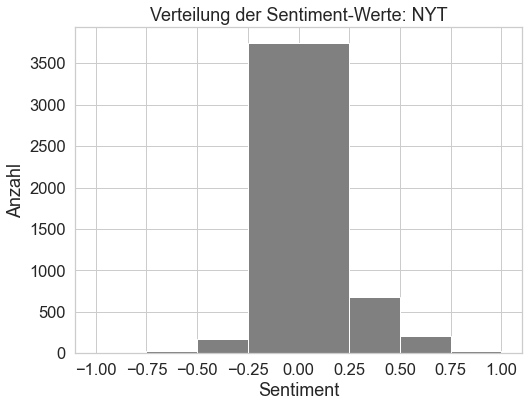

In [13]:
# Visualisierung des Histogramms der Sentiment-Analyse der Tweets.
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax, color="grey")
plt.title("Verteilung der Sentiment-Werte: NYT")
plt.xlabel('Sentiment')
plt.ylabel('Anzahl')
plt.savefig("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_sentiment_tweets.png")
plt.show()

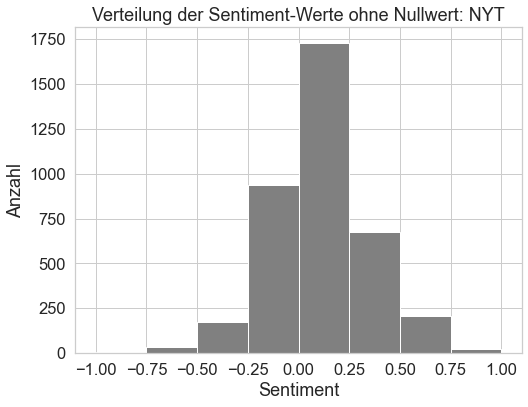

In [14]:
# Visualisierung der Sentiment-Analyse ohne den Nullwert, um die Verteilung der Tweets auf die negativen und positiven Pole differenzierter darstellen zukönnen.

# Entfernung der neutralen Sentiment-Werte bzw. der Nullwerte.
sentiment_zero_df = sentiment_df[sentiment_df.Sentiment != 0]

# Visualisierung des Histogramms der Sentiment-Analyse der Tweets ohne Nullwert.
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_zero_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1], ax=ax, color="grey")
plt.title("Verteilung der Sentiment-Werte ohne Nullwert: NYT")
plt.xlabel('Sentiment')
plt.ylabel('Anzahl')
plt.savefig("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_sentiment_tweets_ohne_null.png")
plt.show()

In [15]:
# Exportieren der Werte der Sentiment-Analyse als .csv-Datei.
sentiment_df.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_sentiment.csv")

In [16]:
# Funktion zur Ermittlung der Subjektivitätswerte der Tweets.
subjectivity_objects = [TextBlob(text) for text in nyt_decapitalized]
subjectivity_objects[0].subjectivity, subjectivity_objects[0]

subjectivity_values = [[text.sentiment.subjectivity, str(text)] for text in subjectivity_objects]
subjectivity_values[0]

subjectivity_df = pd.DataFrame(subjectivity_values, columns=["Subjectivity", "Decapitalized"])
subjectivity_df.head()

,Subjectivity,Decapitalized
0,0.500000,i know it is an ai i know it is not a person o...
1,0.471970,reports of new coronavirus cases continue to d...
2,0.333333,conservative christian groups say mondays us s...
3,0.000000,the police are in some respects a border patro...
4,0.513889,people are desperate for change people are fig...


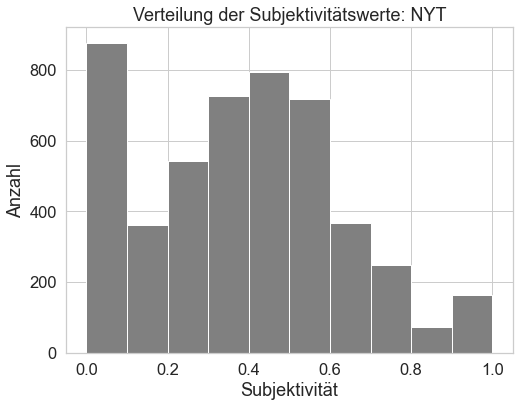

In [17]:
# Visualisierung des Histogramms der Subjektivität der Tweets.
fig, ax = plt.subplots(figsize=(8, 6))
subjectivity_df.hist(bins=[0.0 ,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ax=ax, color="grey")
plt.title("Verteilung der Subjektivitätswerte: NYT")
plt.xlabel('Subjektivität')
plt.ylabel('Anzahl')
plt.savefig("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_subjectivity_tweets.png")
plt.show()

In [18]:
# Exportieren der Werte der Subjektivität als .csv-Datei.
subjectivity_df.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_subjectivity.csv")

# Laden der .csv-Datei der Subjektivität in eine neue Tabelle.
nyt_subjectivity = Table.read_table("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_subjectivity.csv")
nyt_subjectivity 

Unnamed: 0,Subjectivity,Decapitalized
0,0.5,i know it is an ai i know it is not a person one user sa ...
1,0.47197,reports of new coronavirus cases continue to decrease ac ...
2,0.333333,conservative christian groups say mondays us supreme cou ...
3,0,the police are in some respects a border patrol and they ...
4,0.513889,people are desperate for change people are fighting for ...
5,0.275,european regulators are questioning whether apples terms ...
6,0,atlantas mayor keisha lance bottoms announced on monday ...
7,0.5,a prosecutor who quit the roger stone case after attorne ...
8,0.09375,cases of the coronavirus in prisons and jails across the ...
9,0.566667,news analysis social movements are almost always messy a ...


In [19]:
# Laden der Sentiment .csv-Datei in eine neue Tabelle.
nyt_sentiment = Table.read_table("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_sentiment.csv")

# Zusammenführen der Tabellen des Sentiments und der Subjektivität
nyt_sentiment_subjectivity = nyt_sentiment.join("Unnamed: 0", nyt_subjectivity, "Unnamed: 0").drop("Unnamed: 0", "Decapitalized_2").relabeled("Decapitalized","Tweet")

# Exportieren der Werte als .csv-Datei.
nyt_sentiment_subjectivity.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/NYT_sentiment_subjectivity.csv")
nyt_sentiment_subjectivity

Sentiment,Tweet,Subjectivity
-0.1875,i know it is an ai i know it is not a person one user sa ...,0.5
0.271591,reports of new coronavirus cases continue to decrease ac ...,0.47197
0.229167,conservative christian groups say mondays us supreme cou ...,0.333333
0,the police are in some respects a border patrol and they ...,0
-0.0444444,people are desperate for change people are fighting for ...,0.513889
0.025,european regulators are questioning whether apples terms ...,0.275
0,atlantas mayor keisha lance bottoms announced on monday ...,0
0.05,a prosecutor who quit the roger stone case after attorne ...,0.5
-0.00625,cases of the coronavirus in prisons and jails across the ...,0.09375
0.108333,news analysis social movements are almost always messy a ...,0.566667


### 4. Ermittlung der Anzahl der Wörter und der Majuskelschreibung

In [20]:
# Funktion zur Aufteilung der Tweets in einzelne Segmente, um die Anzahl ihrer Wörter zu ermitteln.
def word_count(word):
    return len(word.split())
word_count(nyt_sixth.column('Decapitalized').item(0))

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
tweet_count = nyt_sixth.apply(word_count, 'Decapitalized')

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_upper_table = nyt_sixth.with_column("Word Amount", tweet_count).select("Upper Text", "Decapitalized", "Word Amount")
nyt_upper_table

Upper Text,Decapitalized,Word Amount
['AI'],i know it is an ai i know it is not a person one user sa ...,27
[],reports of new coronavirus cases continue to decrease ac ...,34
"['US', 'LGBT']",conservative christian groups say mondays us supreme cou ...,34
['NYT'],the police are in some respects a border patrol and they ...,26
['US'],people are desperate for change people are fighting for ...,41
[],european regulators are questioning whether apples terms ...,23
[],atlantas mayor keisha lance bottoms announced on monday ...,21
[],a prosecutor who quit the roger stone case after attorne ...,23
[],cases of the coronavirus in prisons and jails across the ...,31
[],news analysis social movements are almost always messy a ...,31


In [21]:
# Summe der gesamten Wortzahl des Korpus.
nyt_wordcount_total = sum(tweet_count)
nyt_wordcount_total

150111

In [22]:
# Funktion zur Umwandlung des Python-Formats "Nested Lists" in eine einzelne "Flatten List", zur Ausgabe der Wörter und Anzahl der Majuskelschreibung.
nyt_upper_word = []
for tweet in nyt_upper:
    nyt_upper_word.extend(tweet)

nyt_upper_word

# Summe der gesamten Anzahl der Majuskelschreibung.
nyt_upper_count = len(nyt_upper_word)
nyt_upper_count

1246

In [23]:
# Funktion zur Ermittlung der Summe der Majuskelschreibung pro Tweet.
nyt_upper_number = []
for word_amount in nyt_upper:
    nyt_upper_number.append(len(word_amount))
    
nyt_upper_number

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
nyt_upper_proportion = nyt_upper_table.with_column("Upper Amount", nyt_upper_number)
nyt_upper_proportion

Upper Text,Decapitalized,Word Amount,Upper Amount
['AI'],i know it is an ai i know it is not a person one user sa ...,27,1
[],reports of new coronavirus cases continue to decrease ac ...,34,0
"['US', 'LGBT']",conservative christian groups say mondays us supreme cou ...,34,2
['NYT'],the police are in some respects a border patrol and they ...,26,1
['US'],people are desperate for change people are fighting for ...,41,1
[],european regulators are questioning whether apples terms ...,23,0
[],atlantas mayor keisha lance bottoms announced on monday ...,21,0
[],a prosecutor who quit the roger stone case after attorne ...,23,0
[],cases of the coronavirus in prisons and jails across the ...,31,0
[],news analysis social movements are almost always messy a ...,31,0
